<a href="https://colab.research.google.com/github/parament-integrator/examples/blob/master/Convergence_Plot_Paper_Version%20-%20Kopie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!NVCC_ARGS="-arch=compute_37" pip install qutip git+https://github.com/parament-integrator/parament#subdirectory=src

  Cloning https://github.com/parament-integrator/parament to /tmp/pip-req-build-hxdnx_d3
  Running command git clone -q https://github.com/parament-integrator/parament /tmp/pip-req-build-hxdnx_d3
  Created wheel for parament: filename=parament-0.1-py3-none-linux_x86_64.whl size=781723 sha256=a075ca05d594b398320e77140c3141b874e24f53f11e7445097f15a82c9ee097
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4lhe0ni/wheels/30/d6/35/c1497ea3f67415126ff9dcde263bc6c57e63b2e80d38e99fc5
Successfully built parament


In [2]:
import sys
import os
import parament
import numpy as np
import scipy.linalg
from numba import njit, prange
import qutip as qu
import matplotlib.pyplot as plt

In [3]:
dtype_base = np.complex128

ox = np.array([[0, 1], [1, 0]], dtype=dtype_base)
oy = np.array([[0, -1j], [1j, 0]], dtype=dtype_base)
oz = np.array([[1, 0], [0, -1]], dtype=dtype_base)
oe = np.array([[1, 0], [0, 1]], dtype=dtype_base)

w0 = 1.0
w1 = 0.1
wrf = 1.0
TSTOP = 6

H0 = w0/2 * oz
H1 = w1/2 * ox
H2 = w1/2 * oy

In [4]:
def Uexact(t):
    dw = w0 - wrf
    gen = np.sqrt(w1**2+dw**2)
    explabM = np.exp(-0.5j*t*wrf)
    explabP = np.exp(0.5j*t*wrf)
    x = 0.5*gen*t
    fact1 = dw/gen
    fact2 = w1/gen
    M1 = explabM*(np.cos(x) + 1j*fact1 * np.sin(x))
    M2 = explabM*(-1j*fact2*np.sin(x))
    M3 = explabP*(-1j*fact2*np.sin(x))
    M4 = explabP*(np.cos(x) - 1j*fact1 * np.sin(x))  
    return np.array([[M1, M2],[M3, M4]])
    

In [5]:
def compare(pts, magnus, quad):
    GPURunner.set_hamiltonian(H0, H1, H2, use_magnus=magnus, quadrature_mode=quad)
    t = np.linspace(0, TSTOP, pts)
    dt = t[1]-t[0]
    carr1 = np.cos(wrf*t)
    carr2 = np.sin(wrf*t)

    outGPU = GPURunner.equiprop(dt, carr1, carr2)
    #u,s,v = np.linalg.svd(outGPU)
    #outGPU = u @ v
    Qout = qu.Qobj(outGPU).tidyup()
    propagator_exact = Uexact(TSTOP)
    Ndiff = outGPU - propagator_exact
    Qexact = qu.Qobj(propagator_exact).tidyup()
    Qdiff = Qout - Qexact
    norm_diff = np.linalg.norm(Qdiff.data.todense())
    return norm_diff

In [6]:
steps = np.logspace(1, 4.5, dtype=int)
steps = np.array([s+1 if s%2 == 0 else s for s in steps])

In [7]:
GPURunner = parament.Parament(precision='fp32')
y1 = np.array([compare(step, True, 'simpson') for step in steps])
y2 = np.array([compare(step, False, 'midpoint') for step in steps])
y3 = np.array([compare(step, False, 'simpson') for step in steps])
GPURunner.destroy()

[]

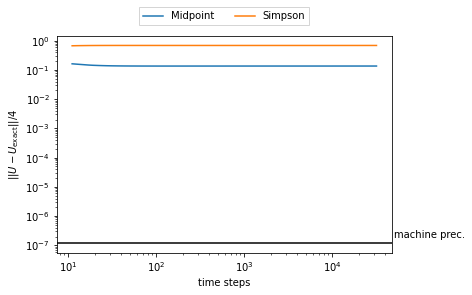

In [8]:
plt.figure()
plt.loglog(steps, np.array(y2)/4, label='Midpoint')
plt.loglog(steps, np.array(y3)/4, label='Simpson')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-23, c='k')
plt.text(5e4, 1.5*2**-23, 'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
           ncol=3, fancybox=False, shadow=False)
plt.plot()

In [9]:
steps = np.array([
            13,      15,      21,      25,      33,      41,      51,
            65,      83,     105,     131,     167,     211,     267,
           337,     427,     541,     683,     865,    1093,    1383,
          1749,    2217,    2799,    3539,    4477,    5663,    7163,
          9061,   11459,   14495,   18335,   23191,   29333,   37101,
         46927,   59357,   75077,   94963,  120113,  151927,  192165,
        243061,  307437,  388863,  491855,  622125,  786897,  995311,
       1258925
])

In [11]:
GPURunner = parament.Parament(precision='fp64')
z1 = np.array([compare(step, True, 'simpson') for step in steps])
z2 = np.array([compare(step, False, 'midpoint') for step in steps])
z3 = np.array([compare(step, False, 'simpson') for step in steps])
GPURunner.destroy()

[]

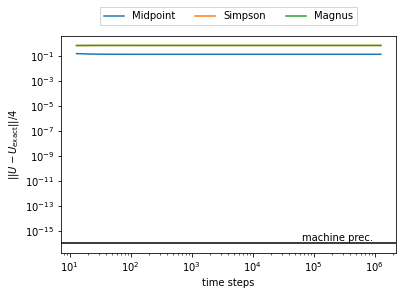

In [12]:
plt.figure()
plt.loglog(steps, np.clip(np.array(z2)/4, 2**-53,100), label='Midpoint')
plt.loglog(steps, np.clip(np.array(z3)/4, 2**-53,100), label='Simpson')
plt.loglog(steps, np.clip(np.array(z1)/4, 2**-53,100), label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-53, c='k')
plt.text(6.5e4, 1.5*2**-53, 'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
           ncol=3, fancybox=False, shadow=False)
plt.plot()